In [1]:
# Import required libraries
%pip install optuna
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
import optuna
import random

# For models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Set constant seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Downgrade numpy for TensorFlow compatibility (run this cell and restart kernel)
%pip install numpy==1.26.4
%pip install imblearn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import random
import numpy as np
import pandas as pd

# ============================================================
# 1. Global deterministic setup (must be at the very top)
# ============================================================

SEED = 42

# Python & NumPy randomness
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Force single-threaded math libs for determinism
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

# ============================================================
# 2. Imports (after env vars)
# ============================================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.pipeline import Pipeline as ImbPipeline

# (Optional) example model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# ============================================================
# 3. Load data and define features
# ============================================================

features = ['RiskScore', 'MonthlyCharges', 'EstimatedCLV', 'tenure', 'ContractRisk', 'PaymentRisk', 'PhoneService', 'AvgChargesPerMonth', 'TechSupport', 'OnlineSecurity', 'TotalCharges', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen']

df = pd.read_csv('final_telco_engineered.csv')

X = df[features]
# Update if your target column has a different name
y = df['Churn']

categorical_cols = ['SeniorCitizen', 'PhoneService', 'TechSupport', 'OnlineSecurity', 'PaperlessBilling', 'PaymentMethod']
numerical_cols = [col for col in features if col not in categorical_cols]

# ============================================================
# 4. Preprocessing pipeline (dense, deterministic)
# ============================================================

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        # For newer sklearn: sparse_output=False
        # For older: use sparse=False (you may get a warning on one of them, but it will still work)
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='drop'
)

# If you get an error about sparse_output, switch to:
# ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False), categorical_cols)

# ============================================================
# 5. Train / val / test split (80 / 10 / 10)
# ============================================================

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.10,
    random_state=SEED,
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.1111,   # 0.1111 * 0.90 ≈ 0.10
    random_state=SEED,
    stratify=y_temp
)

# Ensure target variable is numeric (0/1)
if y_train.dtype == 'O' or y_train.dtype.name == 'category':
    y_train = y_train.map({'No': 0, 'Yes': 1}).astype(int)
    y_val = y_val.map({'No': 0, 'Yes': 1}).astype(int)
    y_test = y_test.map({'No': 0, 'Yes': 1}).astype(int)

# ============================================================
# 6. Fit preprocessor ONLY on training, transform all splits
# ============================================================

X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc   = preprocessor.transform(X_val)
X_test_proc  = preprocessor.transform(X_test)

# Ensure dense float64 (for stable KNN in SMOTE/ENN)
X_train_proc = np.asarray(X_train_proc, dtype=np.float64)
X_val_proc   = np.asarray(X_val_proc,   dtype=np.float64)
X_test_proc  = np.asarray(X_test_proc,  dtype=np.float64)

# ============================================================
# 7. SMOTE + ENN on TRAINING DATA ONLY (deterministic)
# ============================================================

print("Before SMOTE+ENN:")
print(y_train.value_counts())
print("Class distribution:")
print(y_train.value_counts(normalize=True))

# Explicit SMOTE and ENN with fixed random_state
smote = SMOTE(
    random_state=SEED,
    sampling_strategy='auto',  # oversample minority up to majority
    k_neighbors=5
)

enn = EditedNearestNeighbours(
    n_neighbors=3,   # standard ENN
    kind_sel='all'   # deterministic behavior
)

smote_enn = ImbPipeline(steps=[
    ('smote', smote),
    ('enn', enn)
])

X_train_resampled, y_train_resampled = smote_enn.fit_resample(
    X_train_proc,
    y_train
)

print("\nAfter SMOTE+ENN:")
print(y_train_resampled.value_counts())
print("Class distribution:")
print(y_train_resampled.value_counts(normalize=True))

# Use these for training models
X_train_proc = X_train_resampled
y_train      = y_train_resampled

Before SMOTE+ENN:
Churn
0    4138
1    1495
Name: count, dtype: int64
Class distribution:
Churn
0    0.7346
1    0.2654
Name: proportion, dtype: float64


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



After SMOTE+ENN:
Churn
0    4138
1    2697
Name: count, dtype: int64
Class distribution:
Churn
0    0.605413
1    0.394587
Name: proportion, dtype: float64



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[I 2025-12-04 15:57:44,493] A new study created in memory with name: no-name-3ed268a9-f79e-4697-a5a8-34c44bcc031b
  0%|          | 0/50 [00:00<?, ?it/s]2025-12-04 15:57:44.517372: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-12-04 15:57:44.517422: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-12-04 15:57:44.517439: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-12-04 15:57:44.517464: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-04 15

Early stopping at epoch 13; best val F1=0.6555
Trial early stopped at epoch 13 (best val F1=0.6555)
[I 2025-12-04 15:58:22,245] Trial 0 finished with value: 0.6555023923444976 and parameters: {'n_units': 58, 'lr': 0.007969454818643935, 'dropout': 0.36599697090570255, 'batch_size': 90}. Best is trial 0 with value: 0.6555023923444976.


Best trial: 0. Best value: 0.655502:   4%|▍         | 2/50 [00:52<19:13, 24.03s/it]

Early stopping at epoch 8; best val F1=0.6244
Trial early stopped at epoch 8 (best val F1=0.6244)
[I 2025-12-04 15:58:36,681] Trial 1 finished with value: 0.6244131455399061 and parameters: {'n_units': 33, 'lr': 0.00020511104188433984, 'dropout': 0.02904180608409973, 'batch_size': 116}. Best is trial 0 with value: 0.6555023923444976.


Best trial: 2. Best value: 0.661765:   6%|▌         | 3/50 [01:02<14:00, 17.88s/it]

Early stopping at epoch 7; best val F1=0.6618
Trial early stopped at epoch 7 (best val F1=0.6618)
[I 2025-12-04 15:58:47,245] Trial 2 finished with value: 0.6617647058823529 and parameters: {'n_units': 83, 'lr': 0.0026070247583707684, 'dropout': 0.010292247147901223, 'batch_size': 126}. Best is trial 2 with value: 0.6617647058823529.


Best trial: 2. Best value: 0.661765:   8%|▊         | 4/50 [01:50<22:39, 29.55s/it]

Early stopping at epoch 19; best val F1=0.6617
Trial early stopped at epoch 19 (best val F1=0.6617)
[I 2025-12-04 15:59:34,673] Trial 3 finished with value: 0.6616915422885572 and parameters: {'n_units': 110, 'lr': 0.00026587543983272726, 'dropout': 0.09091248360355031, 'batch_size': 49}. Best is trial 2 with value: 0.6617647058823529.


Best trial: 2. Best value: 0.661765:  10%|█         | 5/50 [02:18<21:46, 29.04s/it]

Early stopping at epoch 12; best val F1=0.6569
Trial early stopped at epoch 12 (best val F1=0.6569)
[I 2025-12-04 16:00:02,815] Trial 4 finished with value: 0.6568627450980392 and parameters: {'n_units': 50, 'lr': 0.0011207606211860567, 'dropout': 0.21597250932105788, 'batch_size': 60}. Best is trial 2 with value: 0.6617647058823529.


Best trial: 2. Best value: 0.661765:  12%|█▏        | 6/50 [02:59<24:15, 33.08s/it]

Early stopping at epoch 19; best val F1=0.6567
Trial early stopped at epoch 19 (best val F1=0.6567)
[I 2025-12-04 16:00:43,729] Trial 5 finished with value: 0.6567164179104478 and parameters: {'n_units': 85, 'lr': 0.00019010245319870352, 'dropout': 0.14607232426760908, 'batch_size': 67}. Best is trial 2 with value: 0.6617647058823529.


Best trial: 2. Best value: 0.661765:  14%|█▍        | 7/50 [03:13<19:20, 26.99s/it]

Early stopping at epoch 7; best val F1=0.6500
Trial early stopped at epoch 7 (best val F1=0.6500)
[I 2025-12-04 16:00:58,188] Trial 6 finished with value: 0.65 and parameters: {'n_units': 67, 'lr': 0.0037183641805732083, 'dropout': 0.09983689107917987, 'batch_size': 81}. Best is trial 2 with value: 0.6617647058823529.


Best trial: 2. Best value: 0.661765:  16%|█▌        | 8/50 [03:34<17:34, 25.10s/it]

Early stopping at epoch 7; best val F1=0.6183
Trial early stopped at epoch 7 (best val F1=0.6183)
[I 2025-12-04 16:01:19,235] Trial 7 finished with value: 0.6182669789227166 and parameters: {'n_units': 82, 'lr': 0.0001238513729886094, 'dropout': 0.3037724259507192, 'batch_size': 48}. Best is trial 2 with value: 0.6617647058823529.


Best trial: 2. Best value: 0.661765:  18%|█▊        | 9/50 [03:51<15:25, 22.58s/it]

Early stopping at epoch 9; best val F1=0.6584
Trial early stopped at epoch 9 (best val F1=0.6584)
[I 2025-12-04 16:01:36,264] Trial 8 finished with value: 0.6583541147132169 and parameters: {'n_units': 23, 'lr': 0.007902619549708232, 'dropout': 0.4828160165372797, 'batch_size': 110}. Best is trial 2 with value: 0.6617647058823529.


Best trial: 2. Best value: 0.661765:  20%|██        | 10/50 [04:08<13:49, 20.73s/it]

Early stopping at epoch 7; best val F1=0.6218
Trial early stopped at epoch 7 (best val F1=0.6218)
[I 2025-12-04 16:01:52,868] Trial 9 finished with value: 0.6218097447795824 and parameters: {'n_units': 50, 'lr': 0.0001567993391672301, 'dropout': 0.34211651325607845, 'batch_size': 74}. Best is trial 2 with value: 0.6617647058823529.


Best trial: 2. Best value: 0.661765:  22%|██▏       | 11/50 [04:25<12:50, 19.76s/it]

Early stopping at epoch 11; best val F1=0.6534
Trial early stopped at epoch 11 (best val F1=0.6534)
[I 2025-12-04 16:02:10,425] Trial 10 finished with value: 0.6533665835411472 and parameters: {'n_units': 123, 'lr': 0.0013112992007873715, 'dropout': 0.0037736596581466053, 'batch_size': 124}. Best is trial 2 with value: 0.6617647058823529.


Best trial: 2. Best value: 0.661765:  24%|██▍       | 12/50 [05:09<17:07, 27.03s/it]

Early stopping at epoch 12; best val F1=0.6584
Trial early stopped at epoch 12 (best val F1=0.6584)
[I 2025-12-04 16:02:54,081] Trial 11 finished with value: 0.6584158415841584 and parameters: {'n_units': 109, 'lr': 0.00048246490262402126, 'dropout': 0.10567749851108958, 'batch_size': 36}. Best is trial 2 with value: 0.6617647058823529.


Best trial: 2. Best value: 0.661765:  26%|██▌       | 13/50 [05:37<16:48, 27.27s/it]

Early stopping at epoch 11; best val F1=0.6488
Trial early stopped at epoch 11 (best val F1=0.6488)
[I 2025-12-04 16:03:21,893] Trial 12 finished with value: 0.6487804878048781 and parameters: {'n_units': 100, 'lr': 0.002710416521357971, 'dropout': 0.1772463985222996, 'batch_size': 99}. Best is trial 2 with value: 0.6617647058823529.


Best trial: 2. Best value: 0.661765:  28%|██▊       | 14/50 [06:28<20:41, 34.50s/it]

Early stopping at epoch 10; best val F1=0.6553
Trial early stopped at epoch 10 (best val F1=0.6553)
[I 2025-12-04 16:04:13,093] Trial 13 finished with value: 0.6552567237163814 and parameters: {'n_units': 101, 'lr': 0.00047241152302599475, 'dropout': 0.05948968409301708, 'batch_size': 34}. Best is trial 2 with value: 0.6617647058823529.


Best trial: 2. Best value: 0.661765:  30%|███       | 15/50 [06:59<19:29, 33.41s/it]

Early stopping at epoch 10; best val F1=0.6552
Trial early stopped at epoch 10 (best val F1=0.6552)
[I 2025-12-04 16:04:43,968] Trial 14 finished with value: 0.6551724137931034 and parameters: {'n_units': 128, 'lr': 0.00046465138714988876, 'dropout': 0.002176341728725998, 'batch_size': 52}. Best is trial 2 with value: 0.6617647058823529.


Best trial: 2. Best value: 0.661765:  32%|███▏      | 16/50 [07:14<15:45, 27.80s/it]

Early stopping at epoch 7; best val F1=0.6602
Trial early stopped at epoch 7 (best val F1=0.6602)
[I 2025-12-04 16:04:58,756] Trial 15 finished with value: 0.6601941747572816 and parameters: {'n_units': 86, 'lr': 0.002393719194281379, 'dropout': 0.09083846393860302, 'batch_size': 102}. Best is trial 2 with value: 0.6617647058823529.


Best trial: 2. Best value: 0.661765:  34%|███▍      | 17/50 [07:36<14:18, 26.02s/it]

Early stopping at epoch 13; best val F1=0.6601
Trial early stopped at epoch 13 (best val F1=0.6601)
[I 2025-12-04 16:05:20,643] Trial 16 finished with value: 0.6600985221674877 and parameters: {'n_units': 113, 'lr': 0.0007010478624133058, 'dropout': 0.25850067382583464, 'batch_size': 128}. Best is trial 2 with value: 0.6617647058823529.


Best trial: 2. Best value: 0.661765:  36%|███▌      | 18/50 [08:06<14:39, 27.48s/it]

Early stopping at epoch 16; best val F1=0.6601
Trial early stopped at epoch 16 (best val F1=0.6601)
[I 2025-12-04 16:05:51,500] Trial 17 finished with value: 0.6600985221674877 and parameters: {'n_units': 94, 'lr': 0.00029178313116633696, 'dropout': 0.1597063665436071, 'batch_size': 82}. Best is trial 2 with value: 0.6617647058823529.


Best trial: 2. Best value: 0.661765:  38%|███▊      | 19/50 [08:35<14:21, 27.80s/it]

Early stopping at epoch 9; best val F1=0.6294
Trial early stopped at epoch 9 (best val F1=0.6294)
[I 2025-12-04 16:06:20,041] Trial 18 finished with value: 0.6294416243654822 and parameters: {'n_units': 72, 'lr': 0.0020058163409583246, 'dropout': 0.06370923361264527, 'batch_size': 47}. Best is trial 2 with value: 0.6617647058823529.


Best trial: 2. Best value: 0.661765:  40%|████      | 20/50 [09:02<13:45, 27.52s/it]

Early stopping at epoch 10; best val F1=0.6384
Trial early stopped at epoch 10 (best val F1=0.6384)
[I 2025-12-04 16:06:46,915] Trial 19 finished with value: 0.6384039900249376 and parameters: {'n_units': 116, 'lr': 0.004482146907539755, 'dropout': 0.4322016744050273, 'batch_size': 63}. Best is trial 2 with value: 0.6617647058823529.


Best trial: 2. Best value: 0.661765:  42%|████▏     | 21/50 [09:24<12:33, 25.99s/it]

Early stopping at epoch 9; best val F1=0.6585
Trial early stopped at epoch 9 (best val F1=0.6585)
[I 2025-12-04 16:07:09,327] Trial 20 finished with value: 0.6584766584766585 and parameters: {'n_units': 96, 'lr': 0.001738941370396219, 'dropout': 0.22357572199787287, 'batch_size': 93}. Best is trial 2 with value: 0.6617647058823529.


Best trial: 2. Best value: 0.661765:  44%|████▍     | 22/50 [09:45<11:24, 24.45s/it]

Early stopping at epoch 6; best val F1=0.6456
Trial early stopped at epoch 6 (best val F1=0.6456)
[I 2025-12-04 16:07:30,196] Trial 21 finished with value: 0.6456310679611651 and parameters: {'n_units': 82, 'lr': 0.003944744239503029, 'dropout': 0.096609562772596, 'batch_size': 104}. Best is trial 2 with value: 0.6617647058823529.


Best trial: 2. Best value: 0.661765:  46%|████▌     | 23/50 [10:11<11:07, 24.72s/it]

Early stopping at epoch 15; best val F1=0.6416
Trial early stopped at epoch 15 (best val F1=0.6416)
[I 2025-12-04 16:07:55,549] Trial 22 finished with value: 0.6416040100250626 and parameters: {'n_units': 88, 'lr': 0.0008638604958863395, 'dropout': 0.05420543117388867, 'batch_size': 118}. Best is trial 2 with value: 0.6617647058823529.


Best trial: 2. Best value: 0.661765:  48%|████▊     | 24/50 [10:27<09:40, 22.34s/it]

Early stopping at epoch 7; best val F1=0.6568
Trial early stopped at epoch 7 (best val F1=0.6568)
[I 2025-12-04 16:08:12,341] Trial 23 finished with value: 0.6567901234567901 and parameters: {'n_units': 106, 'lr': 0.0024148053388824264, 'dropout': 0.1280653437795528, 'batch_size': 106}. Best is trial 2 with value: 0.6617647058823529.


Best trial: 2. Best value: 0.661765:  50%|█████     | 25/50 [10:51<09:29, 22.79s/it]

Early stopping at epoch 13; best val F1=0.6584
Trial early stopped at epoch 13 (best val F1=0.6584)
[I 2025-12-04 16:08:36,184] Trial 24 finished with value: 0.6584158415841584 and parameters: {'n_units': 66, 'lr': 0.0014211196158622262, 'dropout': 0.18544382230888878, 'batch_size': 115}. Best is trial 2 with value: 0.6617647058823529.


Best trial: 2. Best value: 0.661765:  52%|█████▏    | 26/50 [11:15<09:14, 23.09s/it]

Early stopping at epoch 10; best val F1=0.6406
Trial early stopped at epoch 10 (best val F1=0.6406)
[I 2025-12-04 16:08:59,962] Trial 25 finished with value: 0.6405867970660146 and parameters: {'n_units': 78, 'lr': 0.005369100319983074, 'dropout': 0.06992246317023523, 'batch_size': 90}. Best is trial 2 with value: 0.6617647058823529.


Best trial: 2. Best value: 0.661765:  54%|█████▍    | 27/50 [11:33<08:16, 21.59s/it]

Early stopping at epoch 6; best val F1=0.6505
Trial early stopped at epoch 6 (best val F1=0.6505)
[I 2025-12-04 16:09:18,070] Trial 26 finished with value: 0.6504854368932039 and parameters: {'n_units': 91, 'lr': 0.002968336245012267, 'dropout': 0.1252374945923665, 'batch_size': 97}. Best is trial 2 with value: 0.6617647058823529.


Best trial: 2. Best value: 0.661765:  56%|█████▌    | 28/50 [12:08<09:23, 25.60s/it]

Early stopping at epoch 14; best val F1=0.6585
Trial early stopped at epoch 14 (best val F1=0.6585)
[I 2025-12-04 16:09:53,027] Trial 27 finished with value: 0.6584766584766585 and parameters: {'n_units': 117, 'lr': 0.0003151766599544728, 'dropout': 0.03595322240441001, 'batch_size': 74}. Best is trial 2 with value: 0.6617647058823529.


Best trial: 2. Best value: 0.661765:  58%|█████▊    | 29/50 [12:29<08:28, 24.19s/it]

Early stopping at epoch 9; best val F1=0.6533
Trial early stopped at epoch 9 (best val F1=0.6533)
[I 2025-12-04 16:10:13,932] Trial 28 finished with value: 0.6532663316582915 and parameters: {'n_units': 74, 'lr': 0.005702122795672835, 'dropout': 0.26620212031245377, 'batch_size': 122}. Best is trial 2 with value: 0.6617647058823529.


Best trial: 2. Best value: 0.661765:  60%|██████    | 30/50 [13:00<08:42, 26.15s/it]

Early stopping at epoch 14; best val F1=0.6584
Trial early stopped at epoch 14 (best val F1=0.6584)
[I 2025-12-04 16:10:44,645] Trial 29 finished with value: 0.6584158415841584 and parameters: {'n_units': 58, 'lr': 0.0008533116427152026, 'dropout': 0.003586507332991984, 'batch_size': 88}. Best is trial 2 with value: 0.6617647058823529.


Best trial: 2. Best value: 0.661765:  62%|██████▏   | 31/50 [13:17<07:25, 23.46s/it]

Early stopping at epoch 6; best val F1=0.6266
Trial early stopped at epoch 6 (best val F1=0.6266)
[I 2025-12-04 16:11:01,818] Trial 30 finished with value: 0.6265664160401002 and parameters: {'n_units': 103, 'lr': 0.008436425496343049, 'dropout': 0.08660398734725028, 'batch_size': 111}. Best is trial 2 with value: 0.6617647058823529.


Best trial: 2. Best value: 0.661765:  64%|██████▍   | 32/50 [13:43<07:18, 24.38s/it]

Early stopping at epoch 11; best val F1=0.6552
Trial early stopped at epoch 11 (best val F1=0.6552)
[I 2025-12-04 16:11:28,343] Trial 31 finished with value: 0.6551724137931034 and parameters: {'n_units': 113, 'lr': 0.0006613644475520923, 'dropout': 0.2686095120523133, 'batch_size': 125}. Best is trial 2 with value: 0.6617647058823529.


Best trial: 2. Best value: 0.661765:  66%|██████▌   | 33/50 [14:13<07:21, 25.99s/it]

Early stopping at epoch 18; best val F1=0.6585
Trial early stopped at epoch 18 (best val F1=0.6585)
[I 2025-12-04 16:11:58,082] Trial 32 finished with value: 0.6585365853658537 and parameters: {'n_units': 121, 'lr': 0.00030681571807187583, 'dropout': 0.31325874576268276, 'batch_size': 128}. Best is trial 2 with value: 0.6617647058823529.


Best trial: 2. Best value: 0.661765:  68%|██████▊   | 34/50 [14:37<06:44, 25.26s/it]

Early stopping at epoch 11; best val F1=0.6517
Trial early stopped at epoch 11 (best val F1=0.6517)
[I 2025-12-04 16:12:21,645] Trial 33 finished with value: 0.6517412935323383 and parameters: {'n_units': 110, 'lr': 0.0016284308471291723, 'dropout': 0.22121288423160462, 'batch_size': 119}. Best is trial 2 with value: 0.6617647058823529.


Best trial: 34. Best value: 0.665025:  70%|███████   | 35/50 [14:58<06:02, 24.17s/it]

Early stopping at epoch 9; best val F1=0.6650
Trial early stopped at epoch 9 (best val F1=0.6650)
[I 2025-12-04 16:12:43,276] Trial 34 finished with value: 0.6650246305418719 and parameters: {'n_units': 94, 'lr': 0.001070003213641543, 'dropout': 0.3797307470351754, 'batch_size': 102}. Best is trial 34 with value: 0.6650246305418719.


Best trial: 34. Best value: 0.665025:  72%|███████▏  | 36/50 [15:26<05:55, 25.36s/it]

Early stopping at epoch 13; best val F1=0.6567
Trial early stopped at epoch 13 (best val F1=0.6567)
[I 2025-12-04 16:13:11,423] Trial 35 finished with value: 0.6567164179104478 and parameters: {'n_units': 88, 'lr': 0.0013119604351089333, 'dropout': 0.40195079063807526, 'batch_size': 102}. Best is trial 34 with value: 0.6650246305418719.


Best trial: 34. Best value: 0.665025:  74%|███████▍  | 37/50 [15:48<05:14, 24.19s/it]

Early stopping at epoch 7; best val F1=0.6468
Trial early stopped at epoch 7 (best val F1=0.6468)
[I 2025-12-04 16:13:32,877] Trial 36 finished with value: 0.6467661691542289 and parameters: {'n_units': 96, 'lr': 0.0022311466223223233, 'dropout': 0.033020435337470004, 'batch_size': 86}. Best is trial 34 with value: 0.6650246305418719.


Best trial: 34. Best value: 0.665025:  76%|███████▌  | 38/50 [16:11<04:46, 23.88s/it]

Early stopping at epoch 9; best val F1=0.6307
Trial early stopped at epoch 9 (best val F1=0.6307)
[I 2025-12-04 16:13:56,027] Trial 37 finished with value: 0.6306695464362851 and parameters: {'n_units': 64, 'lr': 0.00011904859119563208, 'dropout': 0.48520205429389696, 'batch_size': 112}. Best is trial 34 with value: 0.6650246305418719.


Best trial: 34. Best value: 0.665025:  78%|███████▊  | 39/50 [17:02<05:53, 32.14s/it]

Early stopping at epoch 15; best val F1=0.6600
Trial early stopped at epoch 15 (best val F1=0.6600)
[I 2025-12-04 16:14:47,450] Trial 38 finished with value: 0.6600496277915633 and parameters: {'n_units': 80, 'lr': 0.0010129075091378967, 'dropout': 0.4258778058505276, 'batch_size': 71}. Best is trial 34 with value: 0.6650246305418719.


Best trial: 34. Best value: 0.665025:  80%|████████  | 40/50 [17:36<05:24, 32.43s/it]

Early stopping at epoch 9; best val F1=0.6568
Trial early stopped at epoch 9 (best val F1=0.6568)
[I 2025-12-04 16:15:20,535] Trial 39 finished with value: 0.6567901234567901 and parameters: {'n_units': 30, 'lr': 0.003187234773408089, 'dropout': 0.3684770857208115, 'batch_size': 58}. Best is trial 34 with value: 0.6650246305418719.


Best trial: 34. Best value: 0.665025:  82%|████████▏ | 41/50 [17:59<04:27, 29.77s/it]

Early stopping at epoch 9; best val F1=0.6519
Trial early stopped at epoch 9 (best val F1=0.6519)
[I 2025-12-04 16:15:44,122] Trial 40 finished with value: 0.6518518518518519 and parameters: {'n_units': 47, 'lr': 0.0017716972665297861, 'dropout': 0.13690368993281968, 'batch_size': 93}. Best is trial 34 with value: 0.6650246305418719.


Best trial: 34. Best value: 0.665025:  84%|████████▍ | 42/50 [18:25<03:48, 28.62s/it]

Early stopping at epoch 13; best val F1=0.6537
Trial early stopped at epoch 13 (best val F1=0.6537)
[I 2025-12-04 16:16:10,064] Trial 41 finished with value: 0.6536585365853659 and parameters: {'n_units': 107, 'lr': 0.0006040950334101311, 'dropout': 0.19099980589532442, 'batch_size': 128}. Best is trial 34 with value: 0.6650246305418719.


Best trial: 34. Best value: 0.665025:  86%|████████▌ | 43/50 [18:50<03:11, 27.37s/it]

Early stopping at epoch 8; best val F1=0.6384
Trial early stopped at epoch 8 (best val F1=0.6384)
[I 2025-12-04 16:16:34,498] Trial 42 finished with value: 0.6384039900249376 and parameters: {'n_units': 86, 'lr': 0.00018045227061384202, 'dropout': 0.29986117753980734, 'batch_size': 120}. Best is trial 34 with value: 0.6650246305418719.


Best trial: 34. Best value: 0.665025:  88%|████████▊ | 44/50 [19:24<02:57, 29.51s/it]

Early stopping at epoch 9; best val F1=0.6585
Trial early stopped at epoch 9 (best val F1=0.6585)
[I 2025-12-04 16:17:09,003] Trial 43 finished with value: 0.6584766584766585 and parameters: {'n_units': 98, 'lr': 0.0006660978809546513, 'dropout': 0.3534164643549821, 'batch_size': 108}. Best is trial 34 with value: 0.6650246305418719.


Best trial: 34. Best value: 0.665025:  90%|█████████ | 45/50 [19:58<02:33, 30.72s/it]

Early stopping at epoch 19; best val F1=0.6500
Trial early stopped at epoch 19 (best val F1=0.6500)
[I 2025-12-04 16:17:42,560] Trial 44 finished with value: 0.65 and parameters: {'n_units': 92, 'lr': 0.0002558999848415405, 'dropout': 0.24044912718943182, 'batch_size': 114}. Best is trial 34 with value: 0.6650246305418719.


Best trial: 34. Best value: 0.665025:  92%|█████████▏| 46/50 [20:52<02:31, 37.97s/it]

Early stopping at epoch 15; best val F1=0.6568
Trial early stopped at epoch 15 (best val F1=0.6568)
[I 2025-12-04 16:18:37,431] Trial 45 finished with value: 0.6567901234567901 and parameters: {'n_units': 128, 'lr': 0.0003849702492208614, 'dropout': 0.16144837503000523, 'batch_size': 43}. Best is trial 34 with value: 0.6650246305418719.


Best trial: 34. Best value: 0.665025:  94%|█████████▍| 47/50 [21:38<02:00, 40.22s/it]

Early stopping at epoch 19; best val F1=0.6472
Trial early stopped at epoch 19 (best val F1=0.6472)
[I 2025-12-04 16:19:22,898] Trial 46 finished with value: 0.6472019464720195 and parameters: {'n_units': 77, 'lr': 0.00010012078005753865, 'dropout': 0.3237364232017276, 'batch_size': 78}. Best is trial 34 with value: 0.6650246305418719.


Best trial: 34. Best value: 0.665025:  96%|█████████▌| 48/50 [22:11<01:16, 38.13s/it]

Early stopping at epoch 12; best val F1=0.6584
Trial early stopped at epoch 12 (best val F1=0.6584)
[I 2025-12-04 16:19:56,156] Trial 47 finished with value: 0.6584158415841584 and parameters: {'n_units': 104, 'lr': 0.0010729455662463472, 'dropout': 0.38457708675794033, 'batch_size': 99}. Best is trial 34 with value: 0.6650246305418719.


Best trial: 34. Best value: 0.665025:  98%|█████████▊| 49/50 [23:40<00:53, 53.24s/it]

Early stopping at epoch 23; best val F1=0.6601
Trial early stopped at epoch 23 (best val F1=0.6601)
[I 2025-12-04 16:21:24,632] Trial 48 finished with value: 0.6600985221674877 and parameters: {'n_units': 121, 'lr': 0.00023183966418305248, 'dropout': 0.11179916133346054, 'batch_size': 57}. Best is trial 34 with value: 0.6650246305418719.


Best trial: 34. Best value: 0.665025: 100%|██████████| 50/50 [24:16<00:00, 29.14s/it]

Early stopping at epoch 9; best val F1=0.6634
Trial early stopped at epoch 9 (best val F1=0.6634)
[I 2025-12-04 16:22:01,433] Trial 49 finished with value: 0.6633906633906634 and parameters: {'n_units': 114, 'lr': 0.0008141959318330405, 'dropout': 0.28789208597766536, 'batch_size': 66}. Best is trial 34 with value: 0.6650246305418719.
Best FNN hyperparameters: {'n_units': 94, 'lr': 0.001070003213641543, 'dropout': 0.3797307470351754, 'batch_size': 102}


Early stopping at epoch 11; best val F1=0.6585
Final FNN early stopped at epoch 11 (best val F1=0.6585)
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
FNN Test Results:
Accuracy: 0.7915
F1 Score: 0.6162
Precision: 0.6020
Recall (Sensitivity): 0.6310
Specificity: 0.8494
AUC: 0.8474


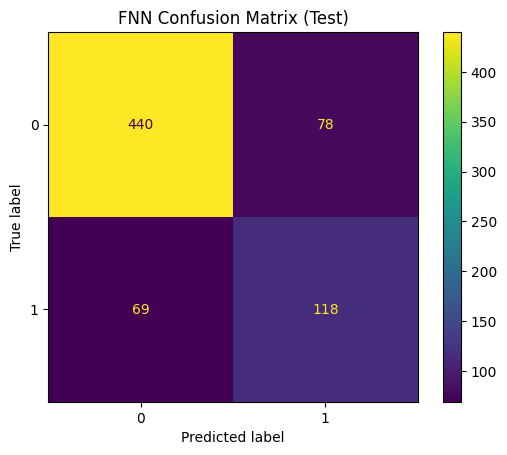

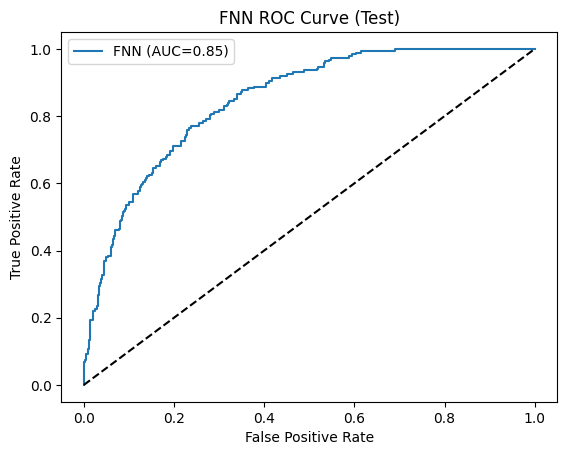

In [4]:
# Feed Forward Neural Network (FNN) with Optuna hyperparameter tuning (F1-based)
%pip install tensorflow-macos tensorflow-metal
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# Deterministic TensorFlow config
tf.keras.utils.set_random_seed(SEED)
try:
    tf.config.experimental.enable_op_determinism()
except Exception:
    pass
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

# Class weights removed (data already oversampled to balance classes)

class F1EarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val, patience=5):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.patience = patience
        self.best_f1 = -1
        self.wait = 0
        self.best_weights = None
        self.stopped_epoch = None
    def on_epoch_end(self, epoch, logs=None):
        preds = (self.model.predict(self.X_val, verbose=0).ravel() > 0.5).astype(int)
        current_f1 = f1_score(self.y_val, preds)
        if current_f1 > self.best_f1:
            self.best_f1 = current_f1
            self.best_weights = self.model.get_weights()
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch + 1
                print(f'Early stopping at epoch {self.stopped_epoch}; best val F1={self.best_f1:.4f}')
                self.model.stop_training = True

def create_fnn_model(trial):
    n_units = trial.suggest_int('n_units', 16, 128)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float('dropout', 0.0, 0.5)
    model = models.Sequential([
        layers.Input(shape=(X_train_proc.shape[1],)),
        layers.Dense(n_units, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(1, activation='sigmoid')
    ])
    optimizer = optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss=losses.BinaryCrossentropy(), metrics=['accuracy'])
    return model

def objective_fnn(trial):
    model = create_fnn_model(trial)
    f1_callback = F1EarlyStopping(X_val_proc, y_val, patience=5)
    model.fit(
        X_train_proc, y_train,
        validation_data=(X_val_proc, y_val),
        epochs=30,
        batch_size=trial.suggest_int('batch_size', 32, 128),
        verbose=0,
        callbacks=[f1_callback]
    )
    if f1_callback.stopped_epoch is not None:
        print(f'Trial early stopped at epoch {f1_callback.stopped_epoch} (best val F1={f1_callback.best_f1:.4f})')
    if f1_callback.best_weights is not None:
        model.set_weights(f1_callback.best_weights)
    return f1_callback.best_f1

study_fnn = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_fnn.optimize(objective_fnn, n_trials=50, show_progress_bar=True)

best_params_fnn = study_fnn.best_params
print('Best FNN hyperparameters:', best_params_fnn)
best_fnn = create_fnn_model(optuna.trial.FixedTrial(best_params_fnn))
f1_callback_final = F1EarlyStopping(X_val_proc, y_val, patience=5)
best_fnn.fit(
    X_train_proc, y_train,
    validation_data=(X_val_proc, y_val),
    epochs=30,
    batch_size=best_params_fnn['batch_size'],
    verbose=0,
    callbacks=[f1_callback_final]
)
if f1_callback_final.stopped_epoch is not None:
    print(f'Final FNN early stopped at epoch {f1_callback_final.stopped_epoch} (best val F1={f1_callback_final.best_f1:.4f})')
if f1_callback_final.best_weights is not None:
    best_fnn.set_weights(f1_callback_final.best_weights)

pred_test_fnn = best_fnn.predict(X_test_proc).ravel()
pred_test_label_fnn = (pred_test_fnn > 0.5).astype(int)
cm_fnn = confusion_matrix(y_test, pred_test_label_fnn)
roc_auc_fnn = roc_auc_score(y_test, pred_test_fnn)
f1_fnn = f1_score(y_test, pred_test_label_fnn)
precision_fnn = precision_score(y_test, pred_test_label_fnn)
recall_fnn = recall_score(y_test, pred_test_label_fnn)
specificity_fnn = cm_fnn[0,0] / (cm_fnn[0,0] + cm_fnn[0,1]) if (cm_fnn[0,0] + cm_fnn[0,1]) > 0 else 0
accuracy_fnn = (cm_fnn[0,0] + cm_fnn[1,1]) / cm_fnn.sum()
print('FNN Test Results:')
print(f'Accuracy: {accuracy_fnn:.4f}')
print(f'F1 Score: {f1_fnn:.4f}')
print(f'Precision: {precision_fnn:.4f}')
print(f'Recall (Sensitivity): {recall_fnn:.4f}')
print(f'Specificity: {specificity_fnn:.4f}')
print(f'AUC: {roc_auc_fnn:.4f}')
ConfusionMatrixDisplay(cm_fnn).plot()
plt.title('FNN Confusion Matrix (Test)')
plt.show()
fpr_fnn, tpr_fnn, _ = roc_curve(y_test, pred_test_fnn)
plt.figure()
plt.plot(fpr_fnn, tpr_fnn, label=f'FNN (AUC={roc_auc_fnn:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('FNN ROC Curve (Test)')
plt.legend()
plt.show()


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[I 2025-12-04 16:31:28,742] A new study created in memory with name: no-name-11b6d1bb-ea7b-402c-b3fb-00c4ccf535ba
  0%|          | 0/50 [00:00<?, ?it/s]2025-12-04 16:31:28.764094: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-12-04 16:31:28.764132: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-12-04 16:31:28.764142: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-12-04 16:31:28.764162: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-04 16

Early stopping at epoch 8; best val F1=0.6586
Trial early stopped at epoch 8 (best val F1=0.6586)
[I 2025-12-04 16:31:50,056] Trial 0 finished with value: 0.6585956416464891 and parameters: {'n_layers': 3, 'n_units': 124, 'lr': 0.0029106359131330704, 'dropout': 0.2993292420985183, 'batch_size': 47}. Best is trial 0 with value: 0.6585956416464891.


Best trial: 0. Best value: 0.658596:   4%|▍         | 2/50 [00:33<12:47, 15.98s/it]

Early stopping at epoch 9; best val F1=0.6553
Trial early stopped at epoch 9 (best val F1=0.6553)
[I 2025-12-04 16:32:02,318] Trial 1 finished with value: 0.6553398058252428 and parameters: {'n_layers': 2, 'n_units': 37, 'lr': 0.005399484409787433, 'dropout': 0.3005575058716044, 'batch_size': 100}. Best is trial 0 with value: 0.6585956416464891.


Best trial: 0. Best value: 0.658596:   6%|▌         | 3/50 [00:50<12:54, 16.48s/it]

Early stopping at epoch 6; best val F1=0.6551
Trial early stopped at epoch 6 (best val F1=0.6551)
[I 2025-12-04 16:32:19,381] Trial 2 finished with value: 0.6550868486352357 and parameters: {'n_layers': 2, 'n_units': 126, 'lr': 0.004622589001020831, 'dropout': 0.10616955533913808, 'batch_size': 49}. Best is trial 0 with value: 0.6585956416464891.


Best trial: 0. Best value: 0.658596:   8%|▊         | 4/50 [01:14<14:48, 19.31s/it]

Early stopping at epoch 9; best val F1=0.6504
Trial early stopped at epoch 9 (best val F1=0.6504)
[I 2025-12-04 16:32:43,028] Trial 3 finished with value: 0.6503667481662592 and parameters: {'n_layers': 2, 'n_units': 61, 'lr': 0.0011207606211860567, 'dropout': 0.21597250932105788, 'batch_size': 60}. Best is trial 0 with value: 0.6585956416464891.


Best trial: 0. Best value: 0.658596:  10%|█         | 5/50 [02:07<23:32, 31.39s/it]

Early stopping at epoch 19; best val F1=0.6567
Trial early stopped at epoch 19 (best val F1=0.6567)
[I 2025-12-04 16:33:35,840] Trial 4 finished with value: 0.6567164179104478 and parameters: {'n_layers': 3, 'n_units': 45, 'lr': 0.0003839629299804173, 'dropout': 0.18318092164684585, 'batch_size': 76}. Best is trial 0 with value: 0.6585956416464891.


Best trial: 0. Best value: 0.658596:  12%|█▏        | 6/50 [03:36<37:32, 51.19s/it]

Early stopping at epoch 14; best val F1=0.6534
Trial early stopped at epoch 14 (best val F1=0.6534)
[I 2025-12-04 16:35:05,473] Trial 5 finished with value: 0.6533665835411472 and parameters: {'n_layers': 4, 'n_units': 51, 'lr': 0.0010677482709481358, 'dropout': 0.29620728443102123, 'batch_size': 36}. Best is trial 0 with value: 0.6585956416464891.


Best trial: 0. Best value: 0.658596:  14%|█▍        | 7/50 [04:06<31:42, 44.24s/it]

Early stopping at epoch 13; best val F1=0.6290
Trial early stopped at epoch 13 (best val F1=0.6290)
[I 2025-12-04 16:35:35,409] Trial 6 finished with value: 0.628992628992629 and parameters: {'n_layers': 3, 'n_units': 48, 'lr': 0.00013492834268013249, 'dropout': 0.4744427686266666, 'batch_size': 125}. Best is trial 0 with value: 0.6585956416464891.


Best trial: 0. Best value: 0.658596:  16%|█▌        | 8/50 [04:40<28:33, 40.79s/it]

Early stopping at epoch 7; best val F1=0.6074
Trial early stopped at epoch 7 (best val F1=0.6074)
[I 2025-12-04 16:36:08,812] Trial 7 finished with value: 0.6074074074074074 and parameters: {'n_layers': 4, 'n_units': 61, 'lr': 0.0001567993391672301, 'dropout': 0.34211651325607845, 'batch_size': 74}. Best is trial 0 with value: 0.6585956416464891.


Best trial: 8. Best value: 0.661765:  18%|█▊        | 9/50 [05:39<31:52, 46.65s/it]

Early stopping at epoch 22; best val F1=0.6618
Trial early stopped at epoch 22 (best val F1=0.6618)
[I 2025-12-04 16:37:08,350] Trial 8 finished with value: 0.6617647058823529 and parameters: {'n_layers': 2, 'n_units': 80, 'lr': 0.00011715937392307068, 'dropout': 0.45466020103939103, 'batch_size': 57}. Best is trial 8 with value: 0.6617647058823529.


Best trial: 8. Best value: 0.661765:  20%|██        | 10/50 [06:25<30:52, 46.31s/it]

Early stopping at epoch 10; best val F1=0.6519
Trial early stopped at epoch 10 (best val F1=0.6519)
[I 2025-12-04 16:37:53,891] Trial 9 finished with value: 0.6518518518518519 and parameters: {'n_layers': 3, 'n_units': 62, 'lr': 0.001096821720752952, 'dropout': 0.2733551396716398, 'batch_size': 49}. Best is trial 8 with value: 0.6617647058823529.


Best trial: 8. Best value: 0.661765:  22%|██▏       | 11/50 [06:55<26:51, 41.32s/it]

Early stopping at epoch 13; best val F1=0.6553
Trial early stopped at epoch 13 (best val F1=0.6553)
[I 2025-12-04 16:38:23,902] Trial 10 finished with value: 0.6552567237163814 and parameters: {'n_layers': 2, 'n_units': 99, 'lr': 0.00032637683158059894, 'dropout': 0.47748436689996926, 'batch_size': 95}. Best is trial 8 with value: 0.6617647058823529.


Best trial: 8. Best value: 0.661765:  24%|██▍       | 12/50 [07:35<25:58, 41.02s/it]

Early stopping at epoch 6; best val F1=0.6569
Trial early stopped at epoch 6 (best val F1=0.6569)
[I 2025-12-04 16:39:04,244] Trial 11 finished with value: 0.656934306569343 and parameters: {'n_layers': 3, 'n_units': 90, 'lr': 0.0026612643350473874, 'dropout': 0.3918148105745084, 'batch_size': 33}. Best is trial 8 with value: 0.6617647058823529.


Best trial: 8. Best value: 0.661765:  26%|██▌       | 13/50 [08:29<27:39, 44.85s/it]

Early stopping at epoch 11; best val F1=0.6617
Trial early stopped at epoch 11 (best val F1=0.6617)
[I 2025-12-04 16:39:57,904] Trial 12 finished with value: 0.6617283950617284 and parameters: {'n_layers': 4, 'n_units': 116, 'lr': 0.0022844340939503728, 'dropout': 0.39550254211266583, 'batch_size': 60}. Best is trial 8 with value: 0.6617647058823529.


Best trial: 8. Best value: 0.661765:  28%|██▊       | 14/50 [09:25<28:56, 48.23s/it]

Early stopping at epoch 12; best val F1=0.6239
Trial early stopped at epoch 12 (best val F1=0.6239)
[I 2025-12-04 16:40:53,947] Trial 13 finished with value: 0.6239316239316239 and parameters: {'n_layers': 4, 'n_units': 106, 'lr': 0.009819389981488664, 'dropout': 0.41123202530048153, 'batch_size': 67}. Best is trial 8 with value: 0.6617647058823529.


Best trial: 8. Best value: 0.661765:  30%|███       | 15/50 [10:33<31:38, 54.25s/it]

Early stopping at epoch 21; best val F1=0.6522
Trial early stopped at epoch 21 (best val F1=0.6522)
[I 2025-12-04 16:42:02,146] Trial 14 finished with value: 0.6521739130434783 and parameters: {'n_layers': 4, 'n_units': 82, 'lr': 0.00046532199007499577, 'dropout': 0.4108634912395722, 'batch_size': 92}. Best is trial 8 with value: 0.6617647058823529.


Best trial: 8. Best value: 0.661765:  32%|███▏      | 16/50 [11:48<34:19, 60.57s/it]

Early stopping at epoch 16; best val F1=0.6569
Trial early stopped at epoch 16 (best val F1=0.6569)
[I 2025-12-04 16:43:17,388] Trial 15 finished with value: 0.656934306569343 and parameters: {'n_layers': 4, 'n_units': 111, 'lr': 0.0020223648114944858, 'dropout': 0.49349313443516535, 'batch_size': 61}. Best is trial 8 with value: 0.6617647058823529.


Best trial: 8. Best value: 0.661765:  34%|███▍      | 17/50 [12:23<29:06, 52.92s/it]

Early stopping at epoch 11; best val F1=0.6585
Trial early stopped at epoch 11 (best val F1=0.6585)
[I 2025-12-04 16:43:52,532] Trial 16 finished with value: 0.6585365853658537 and parameters: {'n_layers': 2, 'n_units': 72, 'lr': 0.0006154260916827948, 'dropout': 0.3626647762088081, 'batch_size': 80}. Best is trial 8 with value: 0.6617647058823529.


Best trial: 8. Best value: 0.661765:  36%|███▌      | 18/50 [12:59<25:26, 47.69s/it]

Early stopping at epoch 8; best val F1=0.6501
Trial early stopped at epoch 8 (best val F1=0.6501)
[I 2025-12-04 16:44:28,038] Trial 17 finished with value: 0.6501240694789082 and parameters: {'n_layers': 3, 'n_units': 91, 'lr': 0.00022512781327677504, 'dropout': 0.06940641877629392, 'batch_size': 58}. Best is trial 8 with value: 0.6617647058823529.


Best trial: 8. Best value: 0.661765:  38%|███▊      | 19/50 [13:51<25:23, 49.15s/it]

Early stopping at epoch 18; best val F1=0.6582
Trial early stopped at epoch 18 (best val F1=0.6582)
[I 2025-12-04 16:45:20,601] Trial 18 finished with value: 0.6581632653061225 and parameters: {'n_layers': 4, 'n_units': 75, 'lr': 0.0017995025195541162, 'dropout': 0.4346918938863009, 'batch_size': 111}. Best is trial 8 with value: 0.6617647058823529.


Best trial: 8. Best value: 0.661765:  40%|████      | 20/50 [14:24<22:06, 44.21s/it]

Early stopping at epoch 9; best val F1=0.6472
Trial early stopped at epoch 9 (best val F1=0.6472)
[I 2025-12-04 16:45:53,296] Trial 19 finished with value: 0.6472019464720195 and parameters: {'n_layers': 2, 'n_units': 114, 'lr': 0.00010152563249559461, 'dropout': 0.005494594621885618, 'batch_size': 85}. Best is trial 8 with value: 0.6617647058823529.


Best trial: 8. Best value: 0.661765:  42%|████▏     | 21/50 [15:35<25:14, 52.22s/it]

Early stopping at epoch 14; best val F1=0.6617
Trial early stopped at epoch 14 (best val F1=0.6617)
[I 2025-12-04 16:47:04,188] Trial 20 finished with value: 0.6617283950617284 and parameters: {'n_layers': 3, 'n_units': 98, 'lr': 0.0006293528732243042, 'dropout': 0.36216401627629813, 'batch_size': 43}. Best is trial 8 with value: 0.6617647058823529.


Best trial: 8. Best value: 0.661765:  44%|████▍     | 22/50 [16:36<25:38, 54.94s/it]

Early stopping at epoch 10; best val F1=0.6554
Trial early stopped at epoch 10 (best val F1=0.6554)
[I 2025-12-04 16:48:05,466] Trial 21 finished with value: 0.655421686746988 and parameters: {'n_layers': 3, 'n_units': 93, 'lr': 0.0006583355817811887, 'dropout': 0.350962901335423, 'batch_size': 42}. Best is trial 8 with value: 0.6617647058823529.


Best trial: 8. Best value: 0.661765:  46%|████▌     | 23/50 [17:25<23:53, 53.09s/it]

Early stopping at epoch 11; best val F1=0.6521
Trial early stopped at epoch 11 (best val F1=0.6521)
[I 2025-12-04 16:48:54,235] Trial 22 finished with value: 0.6520681265206812 and parameters: {'n_layers': 2, 'n_units': 102, 'lr': 0.0001914581832486659, 'dropout': 0.44038048328083534, 'batch_size': 54}. Best is trial 8 with value: 0.6617647058823529.


Best trial: 8. Best value: 0.661765:  48%|████▊     | 24/50 [18:56<27:56, 64.47s/it]

Early stopping at epoch 22; best val F1=0.6601
Trial early stopped at epoch 22 (best val F1=0.6601)
[I 2025-12-04 16:50:25,253] Trial 23 finished with value: 0.6600985221674877 and parameters: {'n_layers': 4, 'n_units': 116, 'lr': 0.0002713199492850408, 'dropout': 0.35729603673927646, 'batch_size': 69}. Best is trial 8 with value: 0.6617647058823529.


Best trial: 8. Best value: 0.661765:  50%|█████     | 25/50 [20:41<31:55, 76.61s/it]

Early stopping at epoch 16; best val F1=0.6585
Trial early stopped at epoch 16 (best val F1=0.6585)
[I 2025-12-04 16:52:10,180] Trial 24 finished with value: 0.6584766584766585 and parameters: {'n_layers': 3, 'n_units': 120, 'lr': 0.0006273070590177214, 'dropout': 0.4448839922968453, 'batch_size': 39}. Best is trial 8 with value: 0.6617647058823529.


Best trial: 8. Best value: 0.661765:  52%|█████▏    | 26/50 [21:22<26:25, 66.07s/it]

Early stopping at epoch 8; best val F1=0.6601
Trial early stopped at epoch 8 (best val F1=0.6601)
[I 2025-12-04 16:52:51,674] Trial 25 finished with value: 0.6601466992665037 and parameters: {'n_layers': 3, 'n_units': 81, 'lr': 0.001524176783121479, 'dropout': 0.23773321369747777, 'batch_size': 65}. Best is trial 8 with value: 0.6617647058823529.


Best trial: 8. Best value: 0.661765:  54%|█████▍    | 27/50 [22:16<23:54, 62.35s/it]

Early stopping at epoch 6; best val F1=0.6617
Trial early stopped at epoch 6 (best val F1=0.6617)
[I 2025-12-04 16:53:45,322] Trial 26 finished with value: 0.6616541353383458 and parameters: {'n_layers': 3, 'n_units': 107, 'lr': 0.004402201129546182, 'dropout': 0.39026757868330564, 'batch_size': 53}. Best is trial 8 with value: 0.6617647058823529.


Best trial: 8. Best value: 0.661765:  56%|█████▌    | 28/50 [23:09<21:51, 59.59s/it]

Early stopping at epoch 6; best val F1=0.6476
Trial early stopped at epoch 6 (best val F1=0.6476)
[I 2025-12-04 16:54:38,502] Trial 27 finished with value: 0.6475770925110133 and parameters: {'n_layers': 4, 'n_units': 97, 'lr': 0.007899570863651721, 'dropout': 0.32486522459536094, 'batch_size': 43}. Best is trial 8 with value: 0.6617647058823529.


Best trial: 8. Best value: 0.661765:  58%|█████▊    | 29/50 [23:58<19:44, 56.43s/it]

Early stopping at epoch 10; best val F1=0.6543
Trial early stopped at epoch 10 (best val F1=0.6543)
[I 2025-12-04 16:55:27,537] Trial 28 finished with value: 0.6542553191489362 and parameters: {'n_layers': 2, 'n_units': 85, 'lr': 0.003294127803066853, 'dropout': 0.37981938165685875, 'batch_size': 56}. Best is trial 8 with value: 0.6617647058823529.


Best trial: 8. Best value: 0.661765:  60%|██████    | 30/50 [25:10<20:18, 60.92s/it]

Early stopping at epoch 6; best val F1=0.6538
Trial early stopped at epoch 6 (best val F1=0.6538)
[I 2025-12-04 16:56:38,926] Trial 29 finished with value: 0.6537530266343826 and parameters: {'n_layers': 3, 'n_units': 74, 'lr': 0.0008118164561076129, 'dropout': 0.17351192690225065, 'batch_size': 32}. Best is trial 8 with value: 0.6617647058823529.


Best trial: 8. Best value: 0.661765:  62%|██████▏   | 31/50 [25:49<17:14, 54.44s/it]

Early stopping at epoch 6; best val F1=0.6364
Trial early stopped at epoch 6 (best val F1=0.6364)
[I 2025-12-04 16:57:18,265] Trial 30 finished with value: 0.6363636363636364 and parameters: {'n_layers': 2, 'n_units': 105, 'lr': 0.0027905669139361745, 'dropout': 0.45641943695348597, 'batch_size': 46}. Best is trial 8 with value: 0.6617647058823529.


Best trial: 8. Best value: 0.661765:  64%|██████▍   | 32/50 [26:41<16:08, 53.83s/it]

Early stopping at epoch 6; best val F1=0.6494
Trial early stopped at epoch 6 (best val F1=0.6494)
[I 2025-12-04 16:58:10,678] Trial 31 finished with value: 0.6494117647058824 and parameters: {'n_layers': 3, 'n_units': 125, 'lr': 0.004403133366038646, 'dropout': 0.40284024513784505, 'batch_size': 52}. Best is trial 8 with value: 0.6617647058823529.


Best trial: 8. Best value: 0.661765:  66%|██████▌   | 33/50 [27:45<16:06, 56.86s/it]

Early stopping at epoch 6; best val F1=0.6540
Trial early stopped at epoch 6 (best val F1=0.6540)
[I 2025-12-04 16:59:14,615] Trial 32 finished with value: 0.6540284360189573 and parameters: {'n_layers': 3, 'n_units': 108, 'lr': 0.0037779083233624128, 'dropout': 0.31602103803991133, 'batch_size': 63}. Best is trial 8 with value: 0.6617647058823529.


Best trial: 8. Best value: 0.661765:  68%|██████▊   | 34/50 [28:31<14:18, 53.63s/it]

Early stopping at epoch 6; best val F1=0.6508
Trial early stopped at epoch 6 (best val F1=0.6508)
[I 2025-12-04 17:00:00,706] Trial 33 finished with value: 0.6508313539192399 and parameters: {'n_layers': 3, 'n_units': 121, 'lr': 0.005684189552479437, 'dropout': 0.28186839859177637, 'batch_size': 71}. Best is trial 8 with value: 0.6617647058823529.


Best trial: 8. Best value: 0.661765:  70%|███████   | 35/50 [29:15<12:38, 50.59s/it]

Early stopping at epoch 7; best val F1=0.6584
Trial early stopped at epoch 7 (best val F1=0.6584)
[I 2025-12-04 17:00:44,183] Trial 34 finished with value: 0.6584158415841584 and parameters: {'n_layers': 2, 'n_units': 116, 'lr': 0.006394640830933436, 'dropout': 0.4979614812830268, 'batch_size': 47}. Best is trial 8 with value: 0.6617647058823529.


Best trial: 8. Best value: 0.661765:  72%|███████▏  | 36/50 [30:56<15:18, 65.59s/it]

Early stopping at epoch 14; best val F1=0.6471
Trial early stopped at epoch 14 (best val F1=0.6471)
[I 2025-12-04 17:02:24,766] Trial 35 finished with value: 0.6470588235294118 and parameters: {'n_layers': 3, 'n_units': 95, 'lr': 0.002241920794674485, 'dropout': 0.3783888255625016, 'batch_size': 53}. Best is trial 8 with value: 0.6617647058823529.


Best trial: 8. Best value: 0.661765:  74%|███████▍  | 37/50 [31:50<13:28, 62.20s/it]

Early stopping at epoch 7; best val F1=0.6584
Trial early stopped at epoch 7 (best val F1=0.6584)
[I 2025-12-04 17:03:19,072] Trial 36 finished with value: 0.6584158415841584 and parameters: {'n_layers': 3, 'n_units': 86, 'lr': 0.004395158467337932, 'dropout': 0.4266585537213021, 'batch_size': 41}. Best is trial 8 with value: 0.6617647058823529.


Best trial: 8. Best value: 0.661765:  76%|███████▌  | 38/50 [33:07<13:18, 66.57s/it]

Early stopping at epoch 17; best val F1=0.6361
Trial early stopped at epoch 17 (best val F1=0.6361)
[I 2025-12-04 17:04:35,838] Trial 37 finished with value: 0.6361323155216285 and parameters: {'n_layers': 4, 'n_units': 32, 'lr': 0.0016710999890378283, 'dropout': 0.46329079049313665, 'batch_size': 79}. Best is trial 8 with value: 0.6617647058823529.


Best trial: 8. Best value: 0.661765:  78%|███████▊  | 39/50 [34:03<11:37, 63.40s/it]

Early stopping at epoch 10; best val F1=0.6587
Trial early stopped at epoch 10 (best val F1=0.6587)
[I 2025-12-04 17:05:31,837] Trial 38 finished with value: 0.6587112171837709 and parameters: {'n_layers': 2, 'n_units': 111, 'lr': 0.0014442153570224897, 'dropout': 0.3266975127711898, 'batch_size': 57}. Best is trial 8 with value: 0.6617647058823529.


Best trial: 8. Best value: 0.661765:  80%|████████  | 40/50 [35:18<11:10, 67.03s/it]

Early stopping at epoch 10; best val F1=0.6316
Trial early stopped at epoch 10 (best val F1=0.6316)
[I 2025-12-04 17:06:47,326] Trial 39 finished with value: 0.631578947368421 and parameters: {'n_layers': 4, 'n_units': 69, 'lr': 0.00010577230191883919, 'dropout': 0.24344904581441912, 'batch_size': 50}. Best is trial 8 with value: 0.6617647058823529.


Best trial: 8. Best value: 0.661765:  82%|████████▏ | 41/50 [36:28<10:12, 68.00s/it]

Early stopping at epoch 9; best val F1=0.6599
Trial early stopped at epoch 9 (best val F1=0.6599)
[I 2025-12-04 17:07:57,617] Trial 40 finished with value: 0.6598984771573604 and parameters: {'n_layers': 3, 'n_units': 102, 'lr': 0.001337974720193446, 'dropout': 0.20819585716164896, 'batch_size': 38}. Best is trial 8 with value: 0.6617647058823529.


Best trial: 8. Best value: 0.661765:  84%|████████▍ | 42/50 [37:10<08:01, 60.20s/it]

Early stopping at epoch 6; best val F1=0.6530
Trial early stopped at epoch 6 (best val F1=0.6530)
[I 2025-12-04 17:08:39,615] Trial 41 finished with value: 0.6529562982005142 and parameters: {'n_layers': 3, 'n_units': 80, 'lr': 0.002422637089439236, 'dropout': 0.25644445413590206, 'batch_size': 66}. Best is trial 8 with value: 0.6617647058823529.


Best trial: 8. Best value: 0.661765:  86%|████████▌ | 43/50 [37:59<06:38, 56.88s/it]

Early stopping at epoch 7; best val F1=0.6499
Trial early stopped at epoch 7 (best val F1=0.6499)
[I 2025-12-04 17:09:28,727] Trial 42 finished with value: 0.6498740554156172 and parameters: {'n_layers': 3, 'n_units': 67, 'lr': 0.0009362945067621703, 'dropout': 0.14968849465944623, 'batch_size': 62}. Best is trial 8 with value: 0.6617647058823529.


Best trial: 43. Best value: 0.668293:  88%|████████▊ | 44/50 [39:02<05:52, 58.72s/it]

Early stopping at epoch 13; best val F1=0.6683
Trial early stopped at epoch 13 (best val F1=0.6683)
[I 2025-12-04 17:10:31,739] Trial 43 finished with value: 0.6682926829268293 and parameters: {'n_layers': 3, 'n_units': 54, 'lr': 0.0012831650678505543, 'dropout': 0.3020914289528811, 'batch_size': 65}. Best is trial 43 with value: 0.6682926829268293.


Best trial: 43. Best value: 0.668293:  90%|█████████ | 45/50 [41:01<06:23, 76.77s/it]

[I 2025-12-04 17:12:30,639] Trial 44 finished with value: 0.6584158415841584 and parameters: {'n_layers': 3, 'n_units': 56, 'lr': 0.0004598185405696955, 'dropout': 0.311598713791893, 'batch_size': 72}. Best is trial 43 with value: 0.6682926829268293.


Best trial: 43. Best value: 0.668293:  92%|█████████▏| 46/50 [42:07<04:53, 73.46s/it]

Early stopping at epoch 6; best val F1=0.6553
Trial early stopped at epoch 6 (best val F1=0.6553)
[I 2025-12-04 17:13:36,388] Trial 45 finished with value: 0.6552567237163814 and parameters: {'n_layers': 2, 'n_units': 43, 'lr': 0.00352255843597722, 'dropout': 0.37749204593753943, 'batch_size': 59}. Best is trial 43 with value: 0.6682926829268293.


Best trial: 43. Best value: 0.668293:  94%|█████████▍| 47/50 [43:06<03:27, 69.10s/it]

Early stopping at epoch 12; best val F1=0.6551
Trial early stopped at epoch 12 (best val F1=0.6551)
[I 2025-12-04 17:14:35,298] Trial 46 finished with value: 0.6550868486352357 and parameters: {'n_layers': 3, 'n_units': 128, 'lr': 0.001126648391609636, 'dropout': 0.2857571272517012, 'batch_size': 86}. Best is trial 43 with value: 0.6682926829268293.


Best trial: 43. Best value: 0.668293:  96%|█████████▌| 48/50 [45:44<03:11, 95.90s/it]

Early stopping at epoch 26; best val F1=0.6386
Trial early stopped at epoch 26 (best val F1=0.6386)
[I 2025-12-04 17:17:13,738] Trial 47 finished with value: 0.6386138613861386 and parameters: {'n_layers': 3, 'n_units': 39, 'lr': 0.0003602720769149866, 'dropout': 0.4181745044678157, 'batch_size': 46}. Best is trial 43 with value: 0.6682926829268293.


Best trial: 43. Best value: 0.668293:  98%|█████████▊| 49/50 [47:09<01:32, 92.45s/it]

Early stopping at epoch 11; best val F1=0.6486
Trial early stopped at epoch 11 (best val F1=0.6486)
[I 2025-12-04 17:18:38,113] Trial 48 finished with value: 0.6486486486486487 and parameters: {'n_layers': 4, 'n_units': 55, 'lr': 0.002084640281896718, 'dropout': 0.3417253142664594, 'batch_size': 128}. Best is trial 43 with value: 0.6682926829268293.


Best trial: 43. Best value: 0.668293: 100%|██████████| 50/50 [49:58<00:00, 59.97s/it] 

Early stopping at epoch 18; best val F1=0.6650
Trial early stopped at epoch 18 (best val F1=0.6650)
[I 2025-12-04 17:21:27,140] Trial 49 finished with value: 0.6650485436893204 and parameters: {'n_layers': 3, 'n_units': 99, 'lr': 0.0007627654520528806, 'dropout': 0.40458733553046433, 'batch_size': 50}. Best is trial 43 with value: 0.6682926829268293.
Best MLP hyperparameters: {'n_layers': 3, 'n_units': 54, 'lr': 0.0012831650678505543, 'dropout': 0.3020914289528811, 'batch_size': 65}


Early stopping at epoch 11; best val F1=0.6569
Final MLP early stopped at epoch 11 (best val F1=0.6569)
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MLP Test Results:
Accuracy: 0.7858
F1 Score: 0.6196
Precision: 0.5857
Recall (Sensitivity): 0.6578
Specificity: 0.8320
AUC: 0.8468


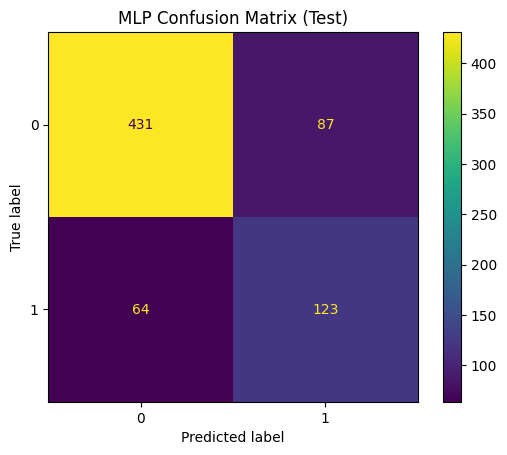

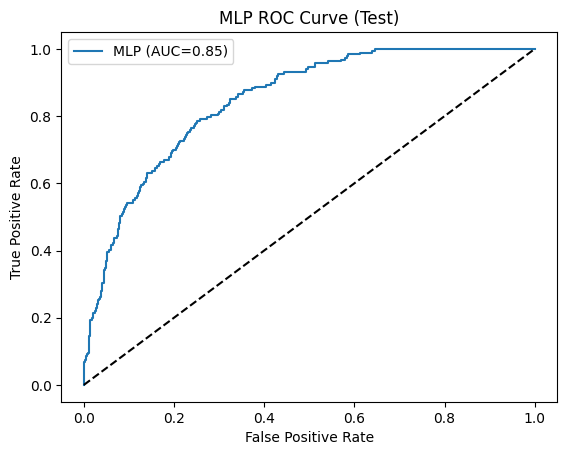

In [4]:
# Multi-Layer Perceptron (MLP) with Optuna hyperparameter tuning (F1-based)
# F1EarlyStopping already defined above; class weights removed
%pip install tensorflow-macos tensorflow-metal
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# Deterministic TensorFlow config
tf.keras.utils.set_random_seed(SEED)
try:
    tf.config.experimental.enable_op_determinism()
except Exception:
    pass
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

# Class weights removed (data already oversampled to balance classes)

class F1EarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val, patience=5):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.patience = patience
        self.best_f1 = -1
        self.wait = 0
        self.best_weights = None
        self.stopped_epoch = None
    def on_epoch_end(self, epoch, logs=None):
        preds = (self.model.predict(self.X_val, verbose=0).ravel() > 0.5).astype(int)
        current_f1 = f1_score(self.y_val, preds)
        if current_f1 > self.best_f1:
            self.best_f1 = current_f1
            self.best_weights = self.model.get_weights()
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch + 1
                print(f'Early stopping at epoch {self.stopped_epoch}; best val F1={self.best_f1:.4f}')
                self.model.stop_training = True
            
def create_mlp_model(trial):
    n_layers = trial.suggest_int('n_layers', 2, 4)
    n_units = trial.suggest_int('n_units', 32, 128)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float('dropout', 0.0, 0.5)
    model = models.Sequential()
    model.add(layers.Input(shape=(X_train_proc.shape[1],)))
    for _ in range(n_layers):
        model.add(layers.Dense(n_units, activation='relu'))
        model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation='sigmoid'))
    optimizer = optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss=losses.BinaryCrossentropy(), metrics=['accuracy'])
    return model

def objective_mlp(trial):
    model = create_mlp_model(trial)
    f1_callback = F1EarlyStopping(X_val_proc, y_val, patience=5)
    model.fit(
        X_train_proc, y_train,
        validation_data=(X_val_proc, y_val),
        epochs=30,
        batch_size=trial.suggest_int('batch_size', 32, 128),
        verbose=0,
        callbacks=[f1_callback]
    )
    if f1_callback.stopped_epoch is not None:
        print(f'Trial early stopped at epoch {f1_callback.stopped_epoch} (best val F1={f1_callback.best_f1:.4f})')
    if f1_callback.best_weights is not None:
        model.set_weights(f1_callback.best_weights)
    return f1_callback.best_f1

study_mlp = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_mlp.optimize(objective_mlp, n_trials=50, show_progress_bar=True)

best_params_mlp = study_mlp.best_params
print('Best MLP hyperparameters:', best_params_mlp)
best_mlp = create_mlp_model(optuna.trial.FixedTrial(best_params_mlp))
f1_callback_final = F1EarlyStopping(X_val_proc, y_val, patience=5)
best_mlp.fit(
    X_train_proc, y_train,
    validation_data=(X_val_proc, y_val),
    epochs=30,
    batch_size=best_params_mlp['batch_size'],
    verbose=0,
    callbacks=[f1_callback_final]
)
if f1_callback_final.stopped_epoch is not None:
    print(f'Final MLP early stopped at epoch {f1_callback_final.stopped_epoch} (best val F1={f1_callback_final.best_f1:.4f})')
if f1_callback_final.best_weights is not None:
    best_mlp.set_weights(f1_callback_final.best_weights)

pred_test_mlp = best_mlp.predict(X_test_proc).ravel()
pred_test_label_mlp = (pred_test_mlp > 0.5).astype(int)
cm_mlp = confusion_matrix(y_test, pred_test_label_mlp)
roc_auc_mlp = roc_auc_score(y_test, pred_test_mlp)
f1_mlp = f1_score(y_test, pred_test_label_mlp)
precision_mlp = precision_score(y_test, pred_test_label_mlp)
recall_mlp = recall_score(y_test, pred_test_label_mlp)
specificity_mlp = cm_mlp[0,0] / (cm_mlp[0,0] + cm_mlp[0,1]) if (cm_mlp[0,0] + cm_mlp[0,1]) > 0 else 0
accuracy_mlp = (cm_mlp[0,0] + cm_mlp[1,1]) / cm_mlp.sum()
print('MLP Test Results:')
print(f'Accuracy: {accuracy_mlp:.4f}')
print(f'F1 Score: {f1_mlp:.4f}')
print(f'Precision: {precision_mlp:.4f}')
print(f'Recall (Sensitivity): {recall_mlp:.4f}')
print(f'Specificity: {specificity_mlp:.4f}')
print(f'AUC: {roc_auc_mlp:.4f}')
ConfusionMatrixDisplay(cm_mlp).plot()
plt.title('MLP Confusion Matrix (Test)')
plt.show()
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, pred_test_mlp)
plt.figure()
plt.plot(fpr_mlp, tpr_mlp, label=f'MLP (AUC={roc_auc_mlp:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MLP ROC Curve (Test)')
plt.legend()
plt.show()